# Color Correction Tutorial 

The color correction module has been developed as a method of normalizing image-based data sets for more accurate image analysis. For simple input and output, a helper function [plantcv.transform.correct_color](https://plantcv.readthedocs.io/en/latest/transform_correct_color/) was developed. We will use the function in the tutorial below but feel free to look at the documentation for more details on the steps that take place within the `pcv.transform.correct_color` function. 

**Conditions**

To run color correction on an image, the following are needed:

* Target and source images must contain a reference from which color values are sampled. The following example uses a 24-color Colorchecker passport.

* A target image (RGB) must be chosen. This image will be of the color profile to which other images will be corrected.

* A source image (RGB), that will be corrected to the target image's color profile

* A mask (gray-scale) of the target image in which background has value 0, and color chips from the colorchecker are labeled with unique values greater than zero, but less than 255.

* A mask (gray-scale) of the source image labeled consistently with the target image's mask.


In [1]:
from plantcv import plantcv as pcv


In [2]:
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "color_tutorial_results.json"
        self.outdir = "."
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


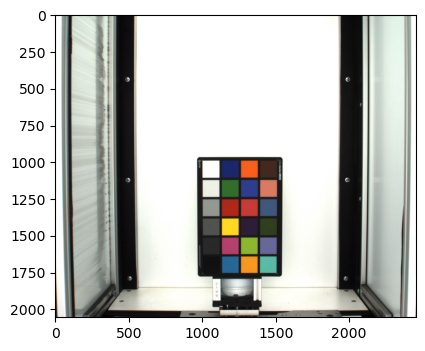

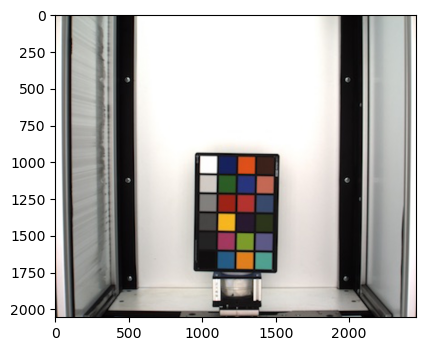

In [3]:
# Read in source and target images 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
target_img, t_path, t_filename = pcv.readimage(filename="./img/target_image.jpg")
source_img, s_path, s_filename = pcv.readimage(filename="./img/source1_img.jpg")


### Complete Color Card 

In [4]:
# Create a labeled color card mask, first use color card finder function 

# This won't print anything out but you can look at the dataframe output 
# to see the chips that the function found. 

# Inputs:
#   rgb_img - RGB image data containing color card 
#   threshold - Optional threshold method; either 'adaptgauss' (default), 'normal', or 'otsu'
#   threshvalue - Optional threhsolding value (default threshvalue = 125) 
#   blurry - Optional boolean; False (default) or if True then image sharpening is applied 
#   background - Optional type of image background; 'dark' (default) or 'light'
dataframe1, start, space = pcv.transform.find_color_card(rgb_img=target_img, background='light')


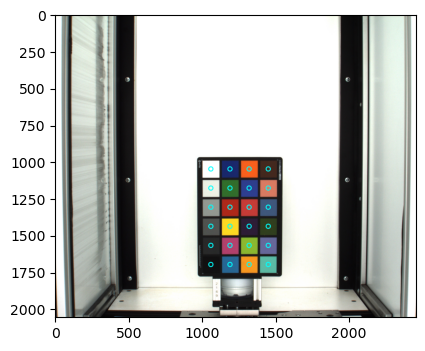

In [5]:
# Make the labeled mask of the target image 

# Inputs: 
#   rgb_img - RGB image data containing color card 
#   radius - Radius of color card chips (masks make circles on chips)
#   start_coord - Two-element tuple of the first chip mask, (starting x, starting y) 
#   spacing - Two-element tuple of the horizontal and vertical spacing between chip masks
#   nrows - Number of chip rows
#   ncols - Number of chip columns 
#   exclude - Optional list of chips to exclude. List largest to smallest index 
target_mask = pcv.transform.create_color_card_mask(target_img, radius=15, start_coord=start, 
                                                   spacing=space, nrows=6, ncols=4)


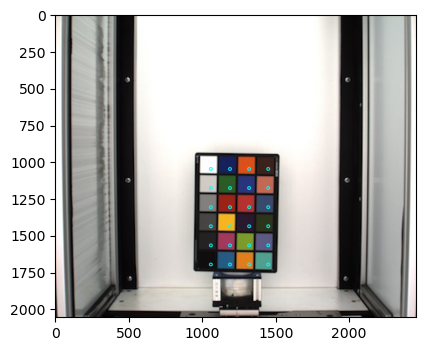

In [6]:
# Our color card chip appears to be in relatively the same position in both the source and target images 
# Try using the same parameters and check to make sure it's appropriate for the source image

source_mask = pcv.transform.create_color_card_mask(source_img, radius=10, start_coord=start, 
                                                   spacing=space, nrows=6, ncols=4)


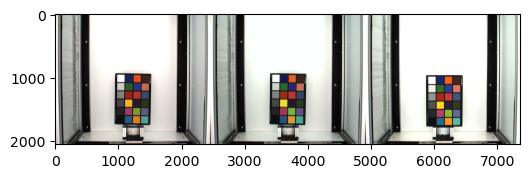

In [7]:
# Run color correction 

# Inputs:
#   target_img - RGB image with color chips
#   target_mask - Grayscale image with color chips and background each represented with unique values 
#   source_img - RGB image with color chips 
#   source_mask - Grayscale image with color chips and background each represented with unique values 
#   output_directory - File path to which the target_matrix, source_matrix, and tranformation_matrix will be saved
tm, sm, transformation_matrix, corrected_img = pcv.transform.correct_color(target_img=target_img, 
                                                                           target_mask=target_mask, 
                                                                           source_img=source_img, 
                                                                           source_mask=source_mask, 
                                                                           output_directory=args.outdir)


In [8]:
# If needed, you can save and load matrices.

# Inputs:
#   matrix - A numpy.matrix or numpy.ndarray
#   filename - Name of a file to which matrix will be saved. Must
#              end in .npz
pcv.transform.save_matrix(matrix=tm, filename='target_matrix.npz')


### Incomplete Color Card 

Sometimes color cards are not fully in frame. Sometimes specific lighting conditions and camera settings will lead to specific color card chips being over/under saturated which will likely affect color correction. We can exclude color card chips to attempt to salvage these types of images. 

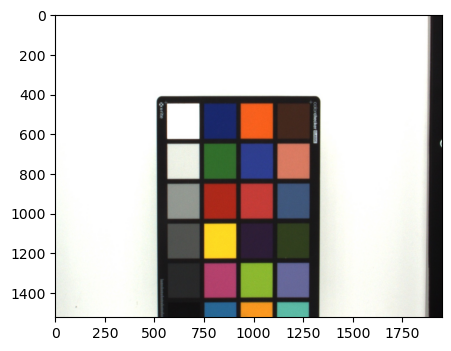

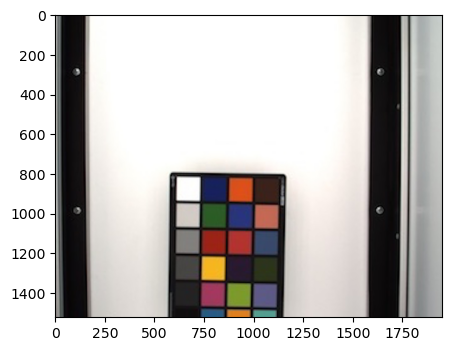

In [9]:
# Read in source and target images in which only part of the color card is in frame 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', or 'gray' 
target_img_partial, tp_path, tp_filename = pcv.readimage(filename="./img/target_image_partial.jpg")
source_img_partial, sp_path, sp_filename = pcv.readimage(filename="./img/source1_img_partial.jpg")


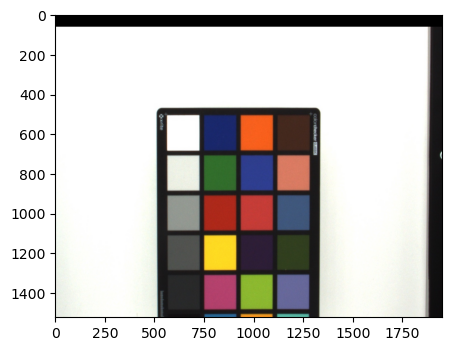

In [10]:
# Shift the target image slightly so that partial color card chips
# don't get detected 

# Inputs:
#   img    = image object
#   number = integer, number of pixels to move image
#   side   = direction to move from "top", "bottom", "right","left"
target_img_partial = pcv.shift_img(img=target_img_partial, number=60, side='top')


In [11]:
# Since our top right color chip is still in frame we can still automatically 
# detect the color card. Start with the partial target image.

# Inputs:
#   rgb_img - RGB image data containing color card 
#   threshold - Optional threshold method; either 'adaptgauss' (default), 'normal', or 'otsu'
#   threshvalue - Optional threhsolding value (default threshvalue = 125) 
#   blurry - Optional boolean; False (default) or if True then image sharpening is applied 
#   background - Optional type of image background; 'dark' (default) or 'light'
dataframe_tp, start_tp, space_tp = pcv.transform.find_color_card(rgb_img=target_img_partial, background='light')


In [12]:
# Next do the same with the source image 

dataframe_sp, start_sp, space_sp = pcv.transform.find_color_card(rgb_img=source_img_partial, background='light')


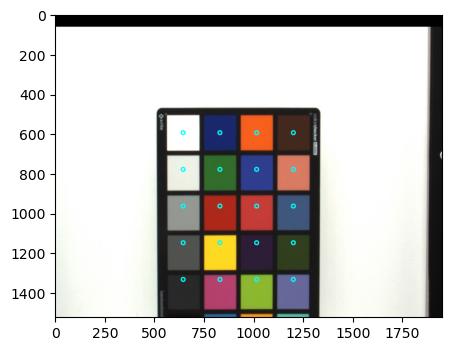

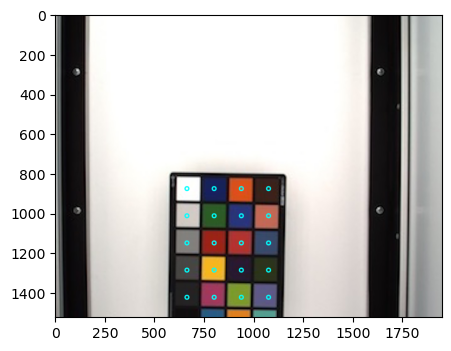

In [13]:
# Create labeled masks for each image 
# Compared to the previous example, where the whole color card was in 
# frame, this time we only have 5 complete rows of color card chips
# so 'nrows' gets updated 

mask_tp = pcv.transform.create_color_card_mask(rgb_img=target_img_partial, radius=10, 
                                               start_coord=start_tp, spacing=space_tp, nrows=5, ncols=4)
mask_sp = pcv.transform.create_color_card_mask(rgb_img=source_img_partial, radius=10, 
                                               start_coord=start_sp, spacing=space_sp, nrows=5, ncols=4)


Although the color card mask regions of interest are not overlapping 
with the edges of the color chips, we can adjust the spacing of the target mask.
Color cards that are slightly tilted are likely to need adjustment 
either in spacing or the starting coordinates if using the 
[pcv.transform.find_color_card](https://plantcv.readthedocs.io/en/latest/transform_correct_color/#automatically-find-a-color-card) function, as this 
function currently has some limitations. 

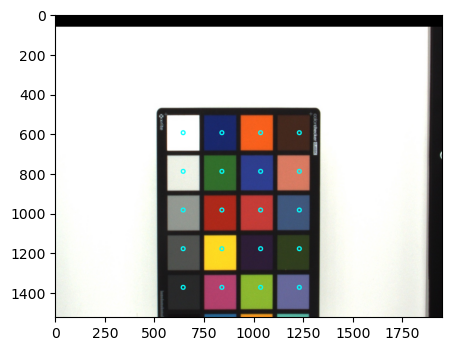

In [14]:
# pcv.find_color_card isoptimized for 4X6 (or 6X4) color cards, so we can adjust spacing. 
# Adjust the target image mask 

mask_tp = pcv.transform.create_color_card_mask(rgb_img=target_img_partial, radius=10, 
                                               start_coord=start_tp, spacing=(195,195), nrows=5, ncols=4)


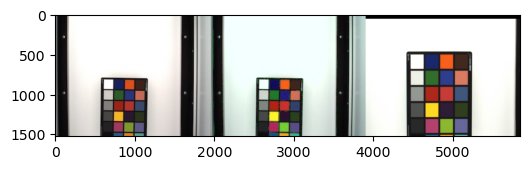

In [15]:
tmp, smp, transformation_matrix_p, corrected_img_p = pcv.transform.correct_color(target_img=target_img_partial, 
                                                                              target_mask=mask_tp, 
                                                                              source_img=source_img_partial, 
                                                                              source_mask=mask_sp, 
                                                                              output_directory=args.outdir)


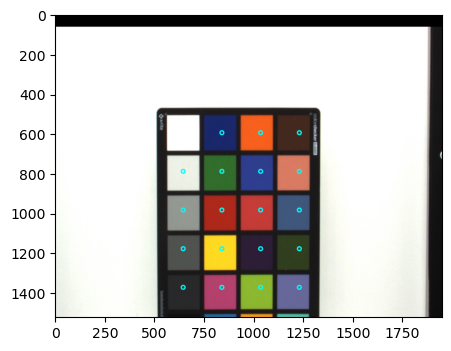

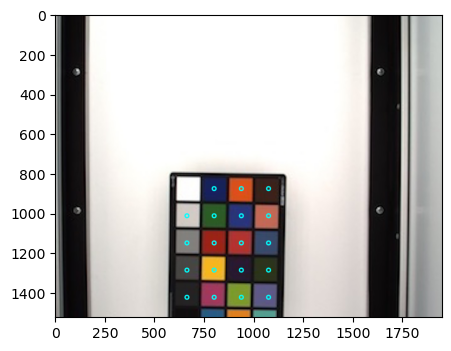

In [16]:
# There's a good chance the white chip of the color card will be 
# fully saturated, which could potentially cause strange things 
# to happen. So to exclude this color chip we can just input 
# exclude = [0] into the pcv.transform.create_color_card_mask
# function (since the white chip is in the top left corner for 
# our example). 

mask_exclude_t = pcv.transform.create_color_card_mask(target_img_partial, radius=10, 
                                                      start_coord=start_tp, spacing=(195,195), 
                                                      nrows=5, ncols=4, exclude=[0])
mask_exclude_s = pcv.transform.create_color_card_mask(source_img_partial, radius=10, 
                                                      start_coord=start_sp, spacing=space_sp, 
                                                      nrows=5, ncols=4, exclude=[0])


### Checking for Problematic Color Card Chips 

We have added a function to quickly check for problematic color card chips. 
The relationship between RGB values in the source image and the target image should be extremely linearly related. 
Plots are labeled with the chip numbers in order to help determine problematic. See the [static PlantCV documentation](https://plantcv.readthedocs.io/en/latest/transform_color_correction_tutorial/#checking-the-color-card-chips)
for some different examples of "bad" color card chips and what they mean. 


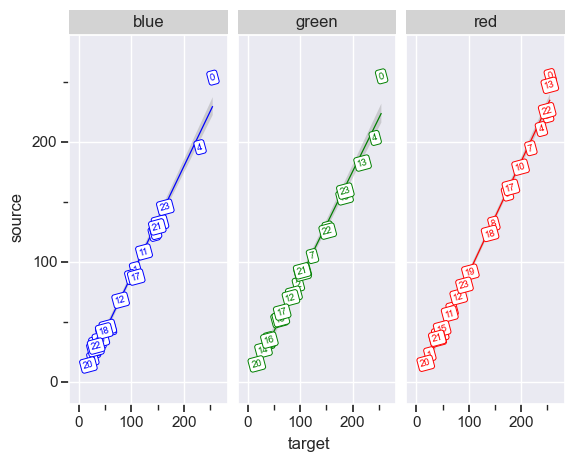

In [17]:
# We can plot use the transformation matrices we already made in the first example.
# Feel free to upload your own images with color cards, create color card masks,
# and check the relationship between chips.

# Inputs: 
#   source_matrix - A matrix containing the average red value, green value, blue value 
#                   for each color chip of the source image (comes from the output of 
#                   pcv.transform.correct_color function)
#   target_matrix - Matrix of color values for each color chip of the target image 
#   num_chips - The number of color card chips included in the matrices
pcv.transform.quick_color_check(source_matrix=sm, target_matrix=tm, num_chips=24)


We can see in the red channel that chip number 13 is not following the linear trend very closely. If you need to examine chip numbers more closely, try using the `%matplotlib notebook` option and zoom to rectangle tool to zoom in on areas of interest. 

<IPython.core.display.Javascript object>


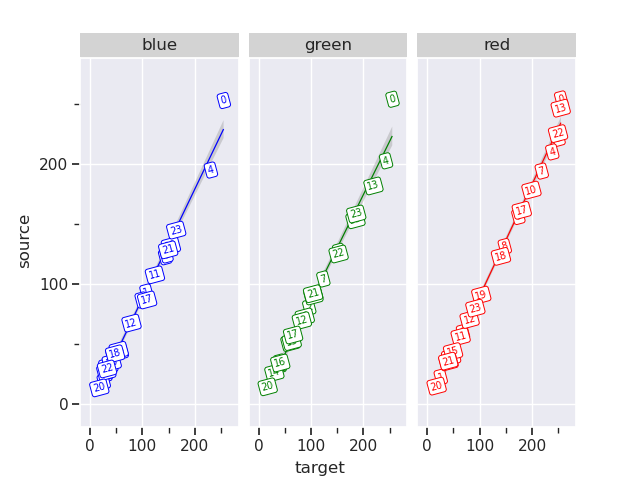

In [18]:
%matplotlib notebook 

pcv.transform.quick_color_check(source_matrix=sm, target_matrix=tm, num_chips=24)
